# Dependencies

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
import yaml
import os
import sys
sys.path.append(os.path.join(os.getcwd(), 'src'))
import pickle
import joblib
import src.utils as utils


**Below is an overview of dataset features**

```
# This is formatted as code
      Column                      #count          #type   # description
      -----------------------     --------------  ------  -----------------
 1.   person_age                  32416 non-null  int64   : Age

 2.   person_income               32416 non-null  int64   : Annual Income

 3.   person_home_ownership       32416 non-null  object  : Status of home ownership (cat)

 4.   person_emp_length           31529 non-null  float64 : Person employment length (years)

 5.   loan_intent                 32416 non-null  object  : Loan intention (Cat)

 6.   loan_grade                  32416 non-null  object  : Loan Grade (A-F)

 7.   loan_amnt                   32416 non-null  int64   : Loan amount (USD)

 8.   loan_int_rate               29321 non-null  float64 : Interest rate (%)

 9.   loan_status                 32416 non-null  int64   : 0-> non-default, 1-> default

 10.  loan_percent_income         32416 non-null  float64 : loan-income ratio (0-1)

 11.  cb_person_default_on_file   32416 non-null  object  : historical default (T / F)

 12.  cb_person_cred_hist_length  32416 non-null  int64   : credit history length (in years?)
```

In [4]:
## load configuration file
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
root_path = os.getcwd()

In [1]:
## load constant variables
TARGET_COL = config['data_source']['target_col']
TEST_SZ = config['data_source']['test_size']
SEED_ST = config['data_source']['random_state']
NUM_COLS = config['data_source']['num_cols']
CAT_COLS = config['data_source']['cat_cols']
CORR_COLS = config['data_source']['corr_cols']
X_TRAIN_PATH = config['pickle_path']['X_train']
X_TEST_PATH = config['pickle_path']['X_test']
X_VALID_PATH = config['pickle_path']['X_valid']
y_TRAIN_PATH = config['pickle_path']['y_train']
y_TEST_PATH = config['pickle_path']['y_test']
y_VALID_PATH = config['pickle_path']['y_valid']

NameError: name 'config' is not defined

In [4]:
fname = fr"{config['data_source']['raw_file']}"
data = utils.load_data(fname)
data.head(5)

Data before dropping shape: (32581, 12)
Data after dropping shape: (32416, 12)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


## 1. Data preparation steps:

1. Insight on missing value
2. Class distribution
3. Split input output
4. Split to train, valid, test sets

### 1.1 insight missing value

In [5]:
utils.percent_missing_values(data)

0.0% missing values of person_age

0.0% missing values of person_income

0.0% missing values of person_home_ownership

2.75% missing values of person_emp_length

0.0% missing values of loan_intent

0.0% missing values of loan_grade

0.0% missing values of loan_amnt

9.56% missing values of loan_int_rate

0.0% missing values of loan_status

0.0% missing values of loan_percent_income

0.0% missing values of cb_person_default_on_file

0.0% missing values of cb_person_cred_hist_length



In [6]:
data.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

**Insights**

 -  There are some missing values in the feature `person_emp_length` and `loan_int_rate` both of which has a float variable. Therefore we have to consider imputation in numerical features.

 - There are no missing values for categorical features. Therefore, our pipeline only need encoding for these features.

### 1.2 Class Distribution

Text(0.5, 1.0, 'Count of Class Instances with Minor-Major Ratio (0.28)')

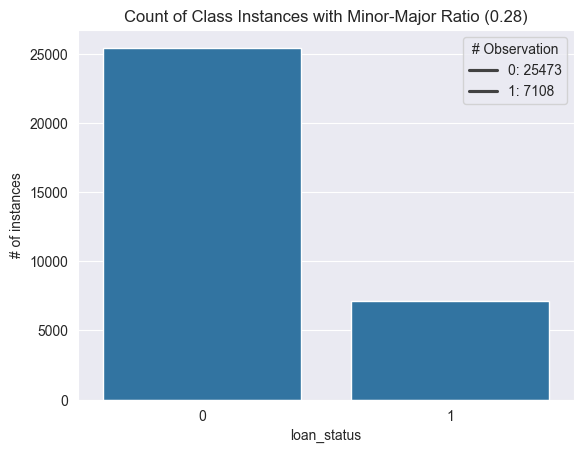

In [7]:
target_counts = data[TARGET_COL].value_counts()

sns.barplot(x=target_counts.index, y=target_counts.values)
ratio= []
labels = []

for i, count in zip(target_counts.index, target_counts.values):
    labels.append(f'{i}: {count}')
    num_str = labels[i][3:]
    num = int(num_str)
    ratio.append(num)

cls_ratio = round(min(ratio) / max(ratio), 2)
plt.legend(title="# Observation", labels=labels)
plt.ylabel("# of instances")
plt.title(f"Count of Class Instances with Minor-Major Ratio ({cls_ratio})")

- There is an imbalance of # Observation in our dataset. we can use sklearn `stratify` function to the target variable in order to get the same distribution for each splitted sets.

### 1.3 Split Input Output

In [8]:
X, y = utils.split_input_output(data, TARGET_COL)

(X) Input shape: (32581, 11)
(y) Output shape: (32581,)


### 1.4 Split Train, Test, Validation Sets

In [9]:
X_train, X_temp, y_train, y_temp, ratio_train, _ = utils.split_train_test(X, y,
                                                    test_size=0.2, seed=123, stratify=y)

X_valid, X_test, y_valid, y_test, ratio_valid, ratio_test = utils.split_train_test(X_temp, y_temp,
                                                    test_size=0.5, seed=123, stratify=y_temp)

 validation of set splits

In [10]:
print(f"X train shape:{X_train.shape} with portion of {round(len(X_train) / len(X),4)}")
print(f"y train shape:{y_train.shape} with portion of {round(len(y_train) / len(y),4)}")
print(f"Ratio of target variable on train set: {ratio_train:.2f}")
print("")

print(f"X valid shape: {X_valid.shape} with portion of {round(len(X_valid) / len(X),4)}")
print(f"y valid shape: {y_valid.shape} with portion of {round(len(y_valid) / len(y),4)}")
print(f"Ratio of target variable on train set: {ratio_valid:.2f}")
print("")

print(f"X test  shape: {X_test.shape} with portion of {round(len(X_test) / len(X),4)}")
print(f"y test  shape: {y_test.shape} with portion of {round(len(y_test) / len(y),4)}")
print(f"Ratio of target variable on train set: {ratio_test:.2f}")

X train shape:(26064, 11) with portion of 0.8
y train shape:(26064,) with portion of 0.8
Ratio of target variable on train set: 0.28

X valid shape: (3258, 11) with portion of 0.1
y valid shape: (3258,) with portion of 0.1
Ratio of target variable on train set: 0.28

X test  shape: (3259, 11) with portion of 0.1
y test  shape: (3259,) with portion of 0.1
Ratio of target variable on train set: 0.28


In [11]:
X_train.head(4)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
29762,45,37500,MORTGAGE,1.0,DEBTCONSOLIDATION,B,5000,11.49,0.13,N,16
2714,25,50000,RENT,5.0,PERSONAL,A,12000,7.88,0.24,N,2
50,24,78000,RENT,4.0,DEBTCONSOLIDATION,D,30000,NaN,0.38,Y,4
28458,31,78504,RENT,2.0,EDUCATION,C,10000,11.41,0.13,N,7


In [12]:
X_valid.head(4)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
25980,31,62000,RENT,2.0,PERSONAL,B,12800,9.62,0.21,N,7
13630,23,95000,MORTGAGE,8.0,MEDICAL,C,7200,14.79,0.08,Y,4
16921,26,126000,MORTGAGE,4.0,DEBTCONSOLIDATION,C,7500,13.92,0.06,N,2
22683,29,57000,MORTGAGE,4.0,MEDICAL,A,2500,6.76,0.04,N,7


In [13]:
X_test.head(4)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
22990,29,34000,RENT,6.0,DEBTCONSOLIDATION,D,8000,16.77,0.24,Y,10
30233,38,48000,RENT,7.0,MEDICAL,B,6000,NaN,0.13,N,17
27415,30,140000,MORTGAGE,6.0,PERSONAL,A,5000,8.90,0.04,N,6
17372,24,95000,OWN,4.0,PERSONAL,C,10000,15.23,0.11,N,4


## serialize data

serialize sets into pickle file

In [14]:
list_data = [X_train, X_valid, X_test, y_train, y_valid, y_test]
list_path = [X_TRAIN_PATH, X_VALID_PATH, X_TEST_PATH, y_TRAIN_PATH, y_VALID_PATH, y_TEST_PATH]

In [15]:
for i, set in enumerate(list_data):
    utils.serialize_data(set, list_path[i])